
#GAN(Generative Adversarial Network)

is a type of **generative AI model** designed to generate new, synthetic data that mimics real data.

**GAN architecture** consists of **2 neural networks** trained simultaneously: a **generator** that generates new data from the training data, and a **discriminator** that evaluates whether the generated data is real (ie from training data) or fake (created by the generator).


**Key Points**:

-**GAN architecture** is based on indirect training through the discriminator in a 'zero-sum' game-theoretic setup: the generator network learns to generate more realistic data from training data sample, and the descriminator network learns to correctly classify real vs. fake data. Over time, the generator improves at producing data that is indistinguishable from real data.

-Original **GANs are unsupervised learning models** - there is no labeled data during training. GAN learns to generate data that is statistically similar to the training dataset, but it does not learn to classify the data (i.e., recognize what the digits represent). It simply learns to model the distribution of the data. The discriminator gets feedback based only on whether the image is real or fake, not based on a specific label (such as "0" or "1").

-In this notebook will train a **GAN on the MNIST training dataset** using Convolutional layers for both the generator and the discriminator to better capture spatial hierarchies in the images, which is important for generating high-quality, complex images. This architecture is known as **Deep Convolutional GAN (or DCGAN)**.

Even though MNIST is a simple dataset, using a DCGAN on MNIST will still outperform a basic GAN in terms of image quality and training stability.

The learning process remains unsupervised because no labels are used, and the goal is to model the data distribution rather than perform classification:
- The discriminator is not concerned with identifying the specific label of the images. It simply distinguishes between real (from MNIST) and fake (generated by the generator).
-The generator does not aim to predict labels or categories, but instead aims to generate realistic images that look like they came from the training data distribution.

For an overview of GAN structure see also: https://developers.google.com/machine-learning/gan/gan_structure



# Training a **DCGAN** (Deep Convolutional Generative Adversarial Network) on the **MNIST dataset** in **Google Colab** using **PyTorch:**


In [1]:
#imports

import torch
torch.manual_seed(42)
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm # to show progress bars in Jupyter notebooks



### **System requirement**

To train GAN, use GPU since GAN (and Neural Networks in general) benefit significantly from GPU acceleration, which can provide massive performance boosts over running on a CPU.


In **Google Colab**, if you're using a GPU, it will automatically use CUDA if it's available. You can check if CUDA is available on your Colab instance by running:
  ```python
  torch.cuda.is_available()
  ```
  
  If the result is `True`, you can safely use the `cuda` device.

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64 # for GAN generator

#Adam Optimizer Hyperparameters:

#Betas are the exponential decay rates for 1st and 2nd moment
beta_1 = 0.5
beta_2 = 0.999

#learning rate
lr = 0.0002 #for GANs

epochs = 20

# Load MNIST Dataset

We will create a trainset from the MNIST dataset using PyTorch's torchvision.datasets, and applying a series of transformations:

In [3]:
from torchvision import datasets, transforms as T

In [4]:
#Set up a transform pipeline for data augmentation and conversion
train_augs = T.Compose ([T.RandomRotation((-20,+20)),T.ToTensor()]) #random rotation of the input image, then convertion into a PyTorch Tensor



In [5]:
#automatic download in directory 'MNIST/' the training MNIST subset (60,000 images of handwritten digits) and apply the transformation pipeline (random rotation and tensor conversion) to each image.
trainset  = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.75MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



torch.Size([1, 28, 28])
60000


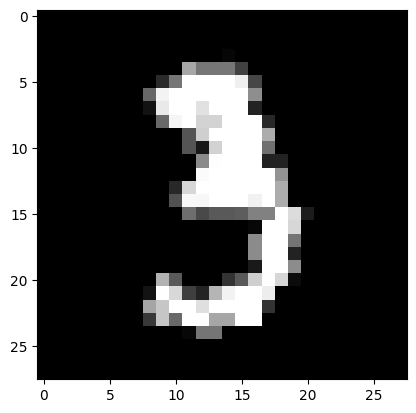

In [6]:
image, label = trainset[10] #image at index 10
print(image.shape) #[c, H, W] where c=1 for gray image
print(len(trainset)) # 60,000 is the size of training MNIST dataset
plt.imshow(image.squeeze(), cmap='gray')

# Load Dataset Into Batches

In [7]:
from torch.utils.data import DataLoader # to load images into batches

from torchvision.utils import make_grid # to plot multiple images in a grid


In [8]:
# Create a DataLoader for the MNIST training set that will be used to:
# train on batches - each batch is a random sample of batch_size(=64) of images (tensor of shape [64, C, H, W])
trainloader = DataLoader(trainset,batch_size = batch_size, shuffle = True)



In [9]:
print("Total number of batches in the trainloader is: ", len(trainloader))


Total number of batches in the trainloader is:  469


In [10]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [11]:
#load 1 batch from the trainloader

#converts trainloader, an iterable to an iterator
dataiter = iter(trainloader)

#loop through images in the batch
images, _ = next(dataiter) # retrieves the next batch of data from the dataiter iterator - where images is a batch of image tensors with shape [batch_size, C, H, W]
print(images.shape)


torch.Size([128, 1, 28, 28])


To plot images from this batch run the function:

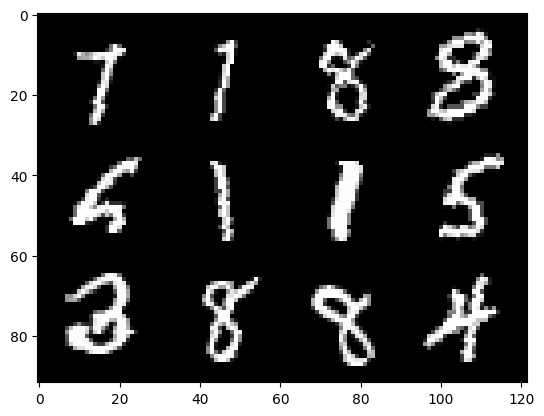

In [12]:
def show_tensor_images(tensor_img, num_images =16, size=(1,28,28)):
  unflat_img = tensor_img.detach().cpu()
  img_grid = make_grid(unflat_img[:num_images], nrow=4)
  plt.imshow(img_grid.permute(1,2,0).squeeze())
  plt.show()

#plot 12 images from this batch:
show_tensor_images(images, num_images=12)



# Define the Discriminator Network:

Discriminator network is a binary classifier that discriminates between real images from fake images

In [13]:
#run this if torch summary is not installed

!pip install torchsummary

In [14]:
# define block consisting of convolutional layer, apply batch normalization and LeakyReLU activation
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                       nn.BatchNorm2d(out_channels),
                       nn.LeakyReLU(0.2))


In [15]:
class Discriminator(nn.Module):


  def __init__(self):
    super(Discriminator, self).__init__()
  #add all blocks - use convolutional layers with different number of units (out_channels)
    self.disc_block1 = get_disc_block(1,16,(3,3), 2)
    self.disc_block2 = get_disc_block(16,32,(5,5), 2)
    self.disc_block3 = get_disc_block(32,64,(5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64,1)

#define forward connection
  def forward(self, images):
    x1 = self.disc_block1(images)
    x2 = self.disc_block2(x1)#output from block1 goes into block2
    x3 = self.disc_block3(x2)#output from block2 goes into block3
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5


# Define the Generator Network

A Generator Network generates realistic fake images using random noise

In [16]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
                         nn.Tanh())


  return nn.Sequential(
                       nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
                       nn.BatchNorm2d(out_channels),
                       nn.ReLU()
                       )

In [17]:
#create Generator class network
class Generator(nn.Module):
  def __init__(self, noise_dim): #add as param
    super(Generator, self).__init__()
    self.noise_dim = noise_dim # attribute
    self.gen_block1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.gen_block2 = get_gen_block(256, 128, (4,4), 1)
    self.gen_block3 = get_gen_block(128, 64, (3,3), 2)
    self.gen_block4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, noise):
    #reshape noise vector
    x = noise.view(len(noise), noise_dim, 1, 1)
    x1 = self.gen_block1(x)
    x2 = self.gen_block2(x1)
    x3 = self.gen_block3(x2)
    x4 = self.gen_block4(x3)
    return x4

In [18]:
# Replace random initialized weights of D and G with normal weights to get robust training
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [19]:
D = Discriminator().apply(weights_init)
G = Generator(noise_dim).apply(weights_init)

# Create the real and fake Loss Functions and Load Optimizer

We will train the discriminator on real images (labeled as 1) and fake images (labeled as 0)

In [20]:
def real_loss(disc_predict):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_predict)
  loss = criterion(disc_predict, ground_truth)
  return loss

def fake_loss(disc_predict):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_predict)
  loss = criterion(disc_predict, ground_truth)
  return loss

In [21]:
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


# Train the GAN model:

define training loop to iteratively improve both the **discriminator** and the **generator** in the GAN framework.Here's how we set up the training loop for GANs:

- Train the Discriminator on real and fake images.

- Train the Generator to create fake images that the discriminator classifies as real.

The training will continue until the generator produces increasingly more realistic fake data that the discriminator can no longer distinguish them.

In [22]:
# Move models to the appropriate device (GPU if available)
G.to(device)
D.to(device)

Discriminator(
  (disc_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (disc_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (disc_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

  0%|          | 0/469 [00:00<?, ?it/s]

D_loss: 0.6937, G_loss: 0.6559


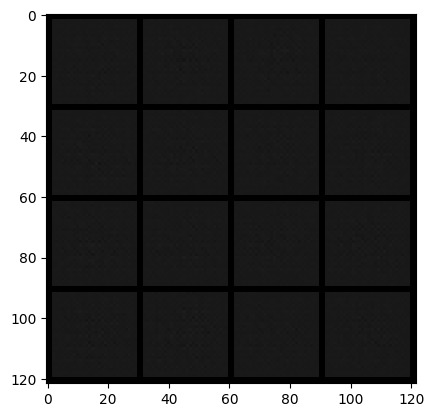

D_loss: 0.6936, G_loss: 0.6560


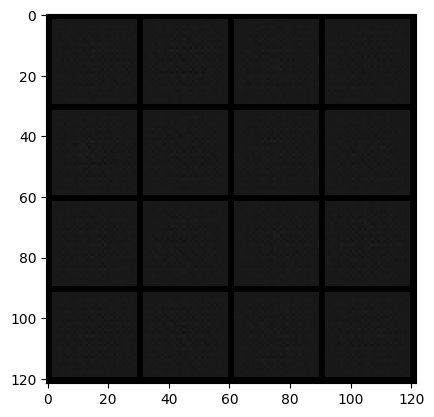

D_loss: 0.6936, G_loss: 0.6561


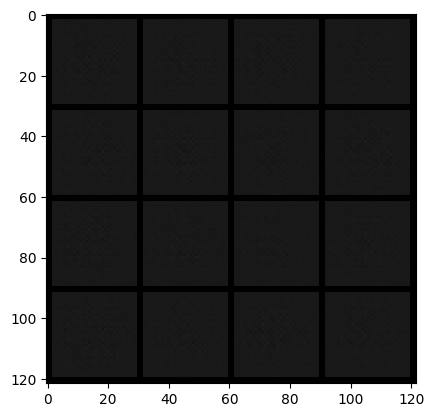

D_loss: 0.6935, G_loss: 0.6562


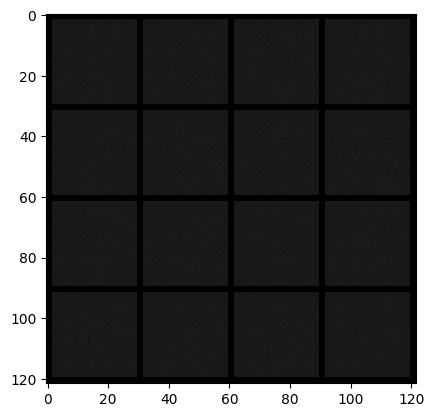

D_loss: 0.6935, G_loss: 0.6563


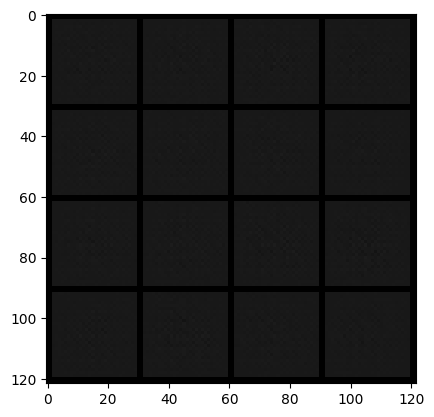

D_loss: 0.6935, G_loss: 0.6564


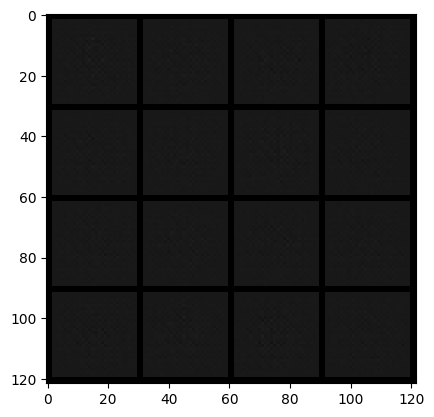

D_loss: 0.6934, G_loss: 0.6565


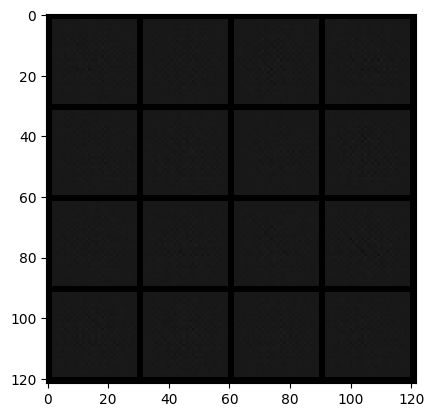

D_loss: 0.6934, G_loss: 0.6567


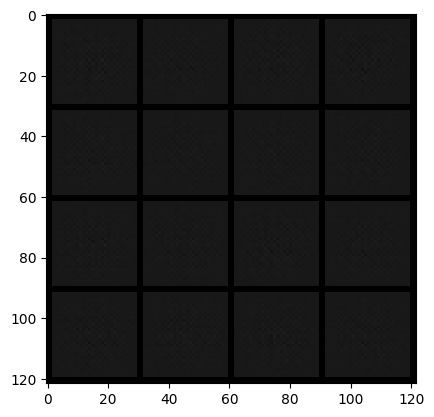

D_loss: 0.6934, G_loss: 0.6568


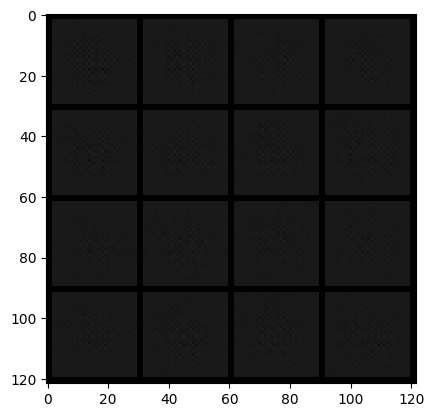

D_loss: 0.6933, G_loss: 0.6569


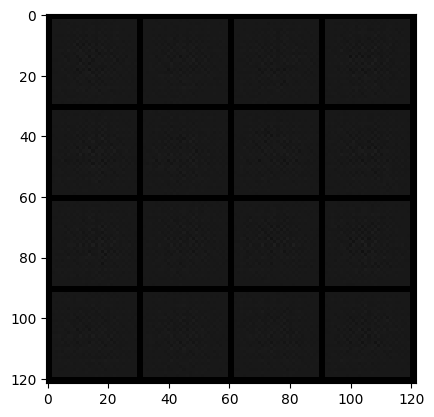

D_loss: 0.6933, G_loss: 0.6570


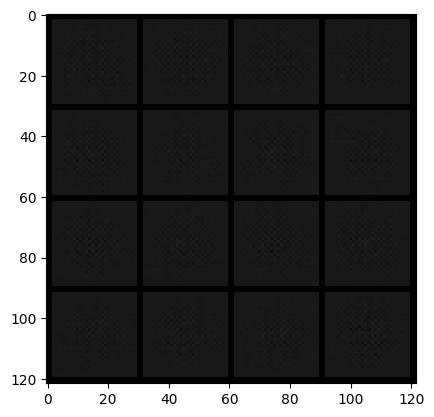

D_loss: 0.6933, G_loss: 0.6572


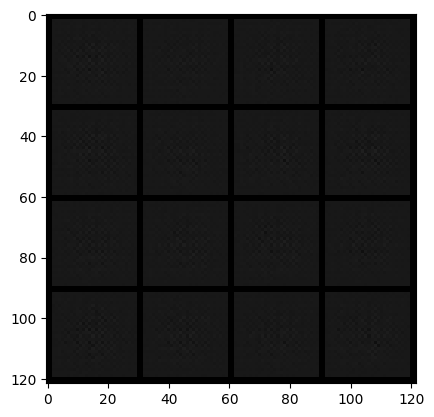

D_loss: 0.6932, G_loss: 0.6573


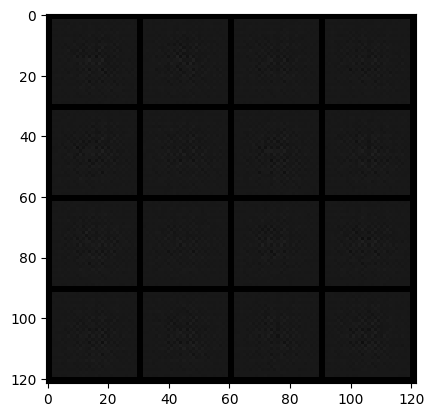

D_loss: 0.6932, G_loss: 0.6574


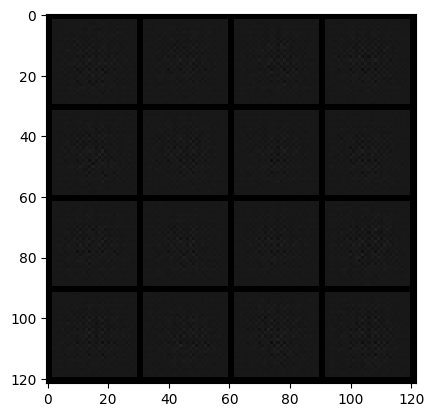

D_loss: 0.6931, G_loss: 0.6576


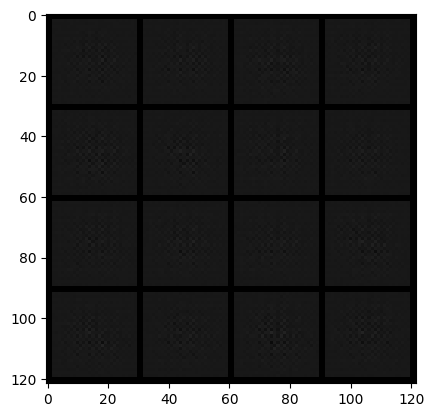

D_loss: 0.6931, G_loss: 0.6577


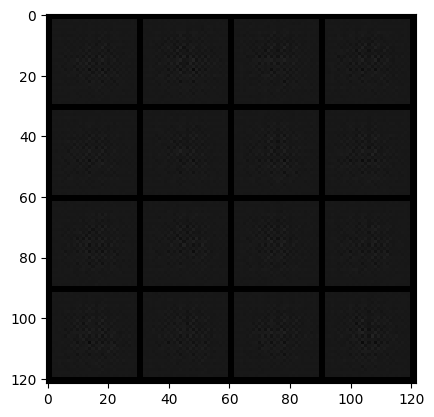

D_loss: 0.6931, G_loss: 0.6578


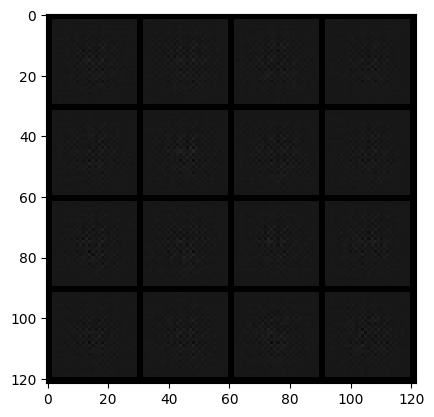

D_loss: 0.6930, G_loss: 0.6579


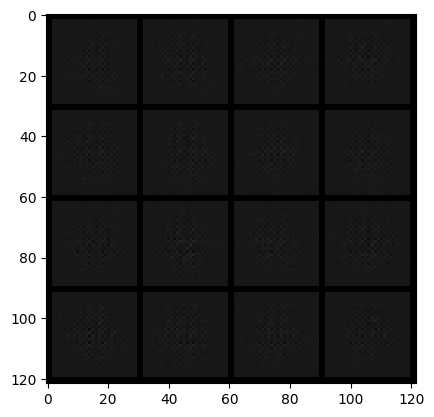

D_loss: 0.6930, G_loss: 0.6581


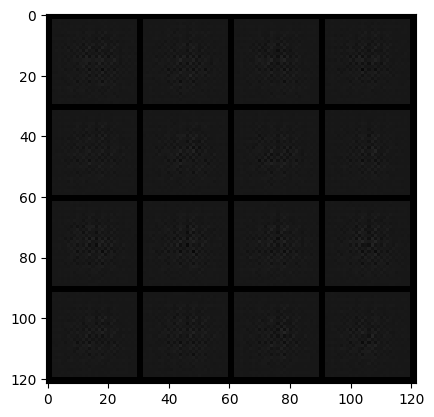

D_loss: 0.6929, G_loss: 0.6582


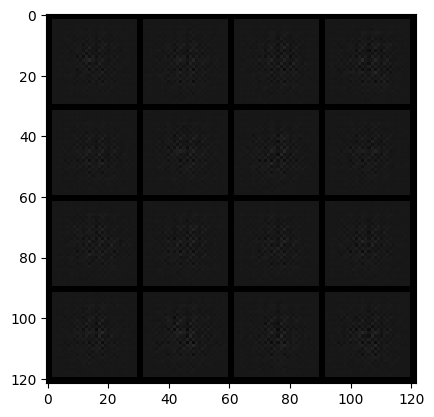

D_loss: 0.6929, G_loss: 0.6583


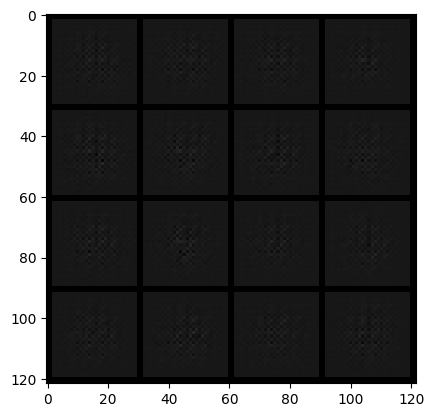

D_loss: 0.6929, G_loss: 0.6585


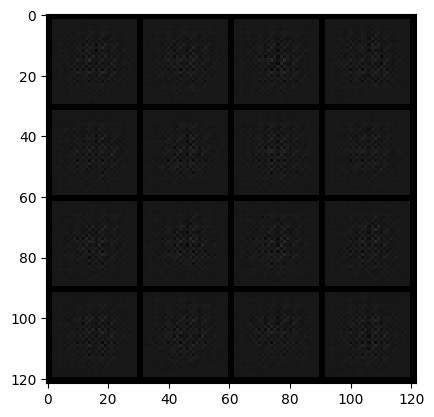

D_loss: 0.6928, G_loss: 0.6586


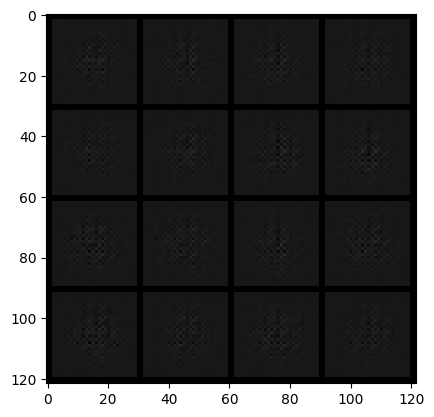

D_loss: 0.6928, G_loss: 0.6587


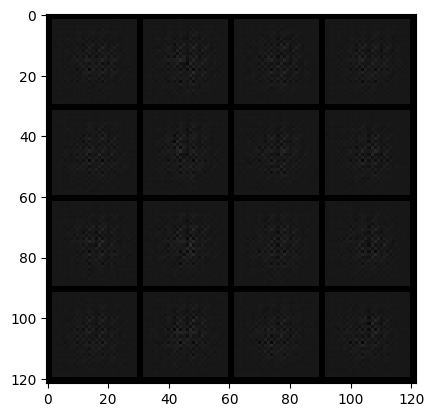

D_loss: 0.6927, G_loss: 0.6588


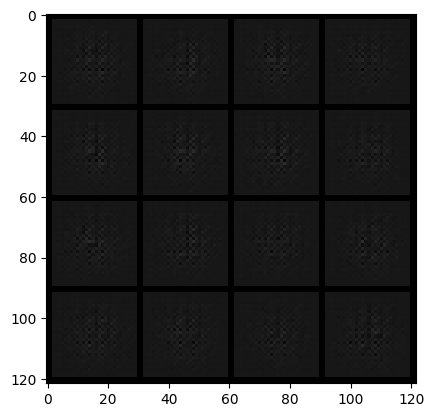

D_loss: 0.6927, G_loss: 0.6590


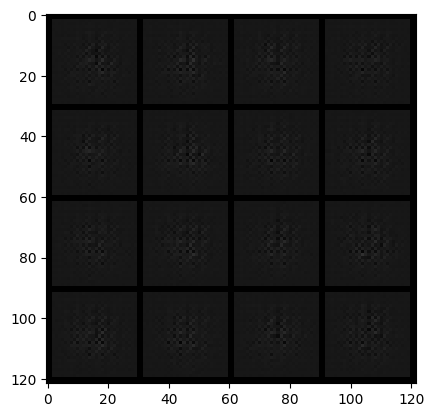

D_loss: 0.6927, G_loss: 0.6591


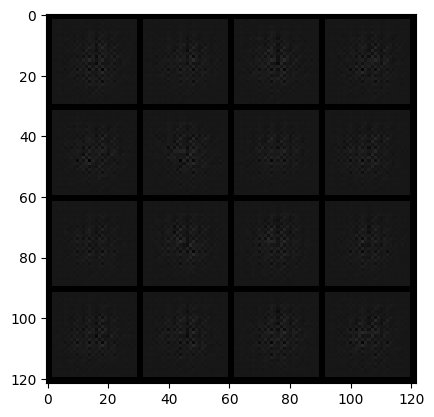

D_loss: 0.6926, G_loss: 0.6592


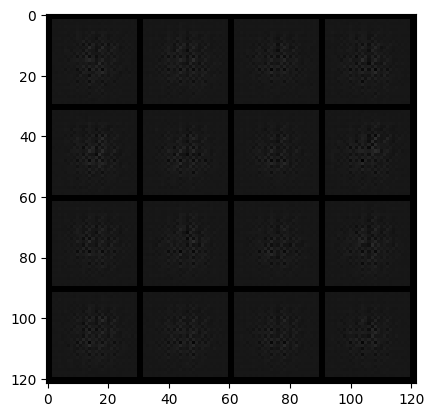

D_loss: 0.6926, G_loss: 0.6594


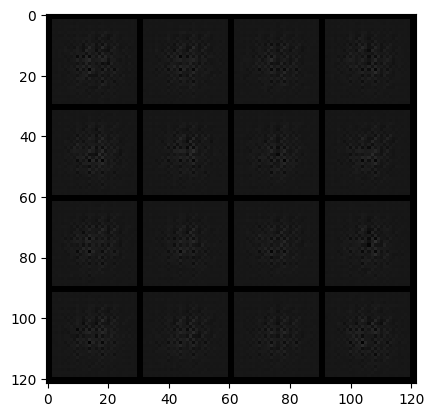

D_loss: 0.6925, G_loss: 0.6595


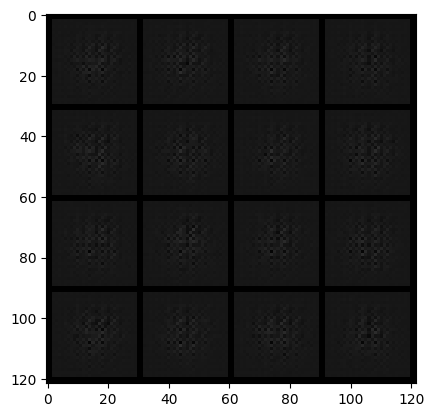

D_loss: 0.6925, G_loss: 0.6596


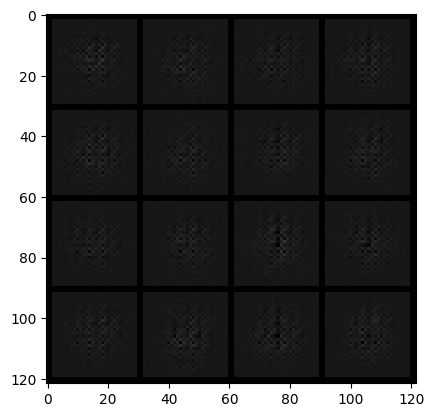

D_loss: 0.6924, G_loss: 0.6598


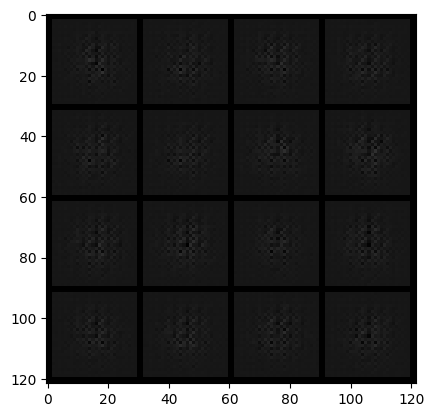

D_loss: 0.6924, G_loss: 0.6599


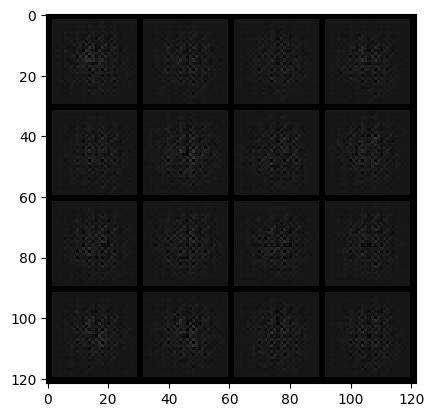

D_loss: 0.6923, G_loss: 0.6600


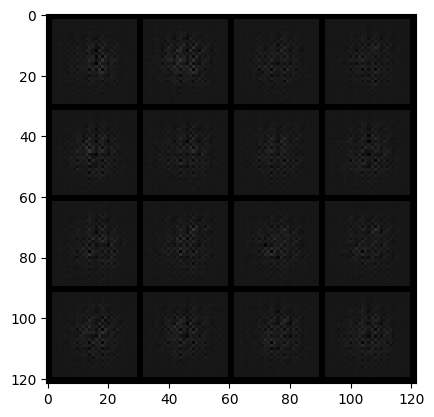

D_loss: 0.6923, G_loss: 0.6601


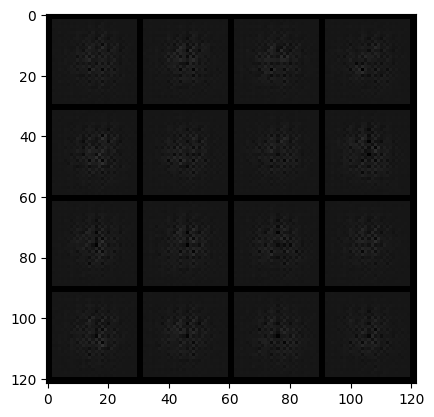

D_loss: 0.6923, G_loss: 0.6603


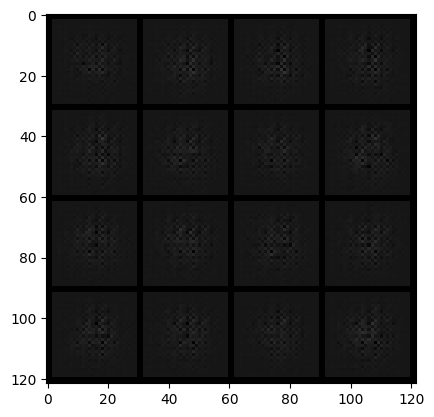

D_loss: 0.6922, G_loss: 0.6604


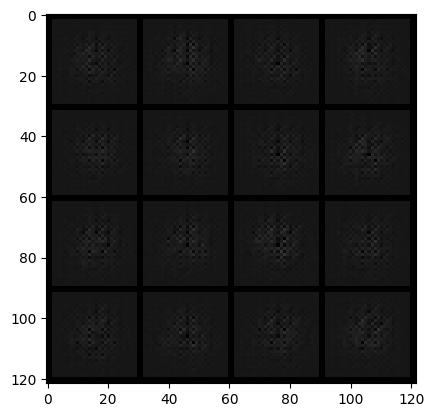

D_loss: 0.6922, G_loss: 0.6605


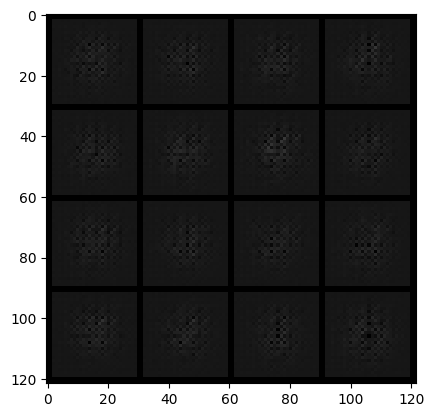

D_loss: 0.6921, G_loss: 0.6607


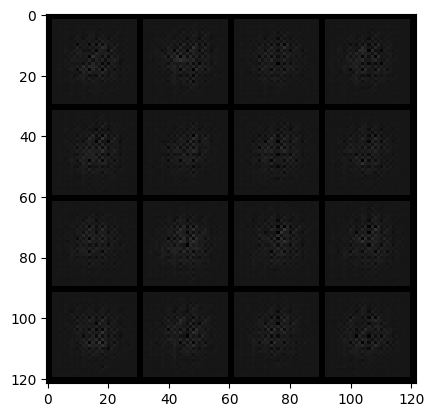

D_loss: 0.6921, G_loss: 0.6608


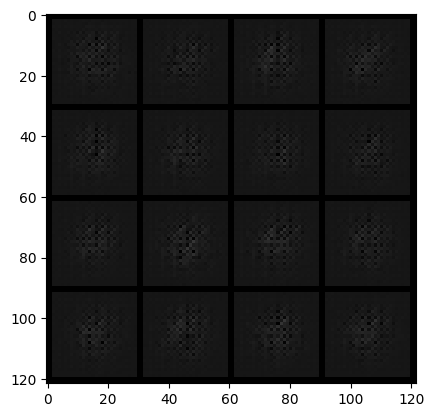

D_loss: 0.6920, G_loss: 0.6609


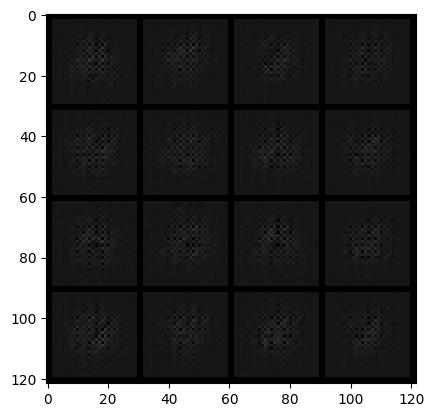

D_loss: 0.6920, G_loss: 0.6610


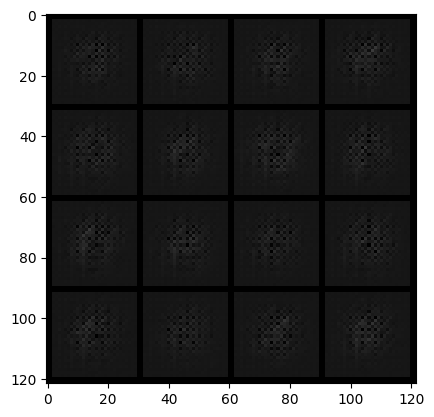

D_loss: 0.6920, G_loss: 0.6612


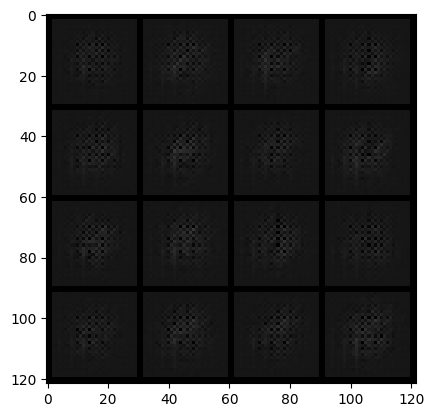

D_loss: 0.6919, G_loss: 0.6613


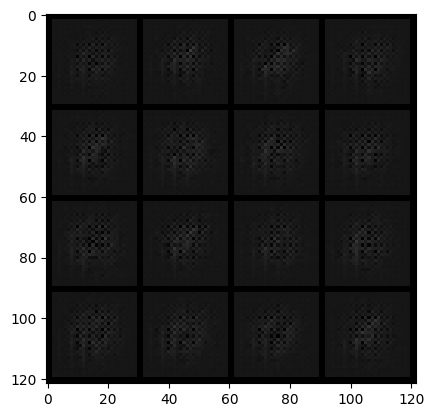

D_loss: 0.6919, G_loss: 0.6614


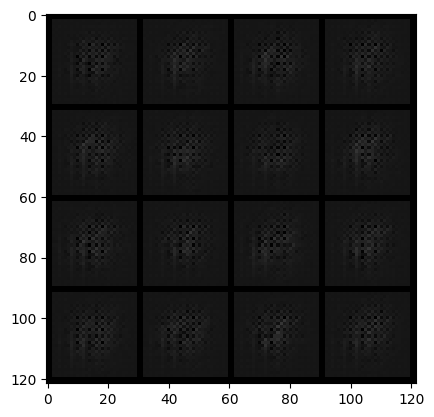

D_loss: 0.6918, G_loss: 0.6615


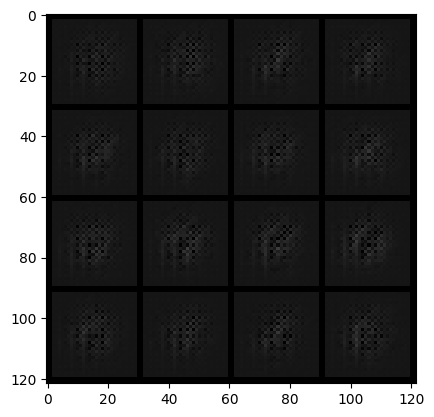

D_loss: 0.6918, G_loss: 0.6617


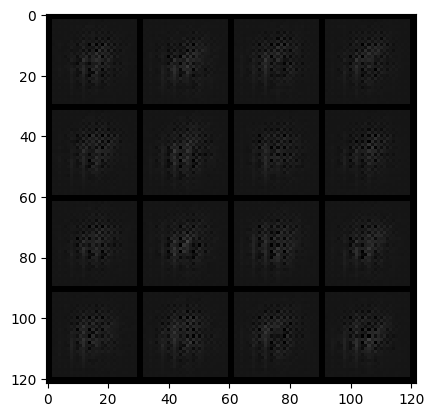

D_loss: 0.6918, G_loss: 0.6618


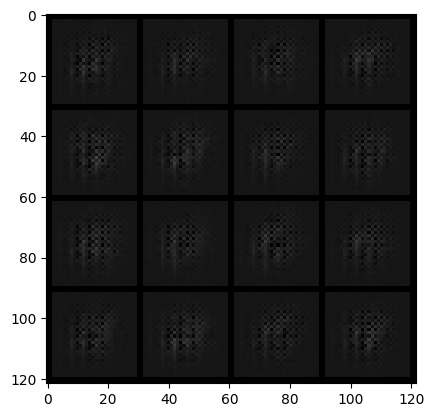

D_loss: 0.6917, G_loss: 0.6619


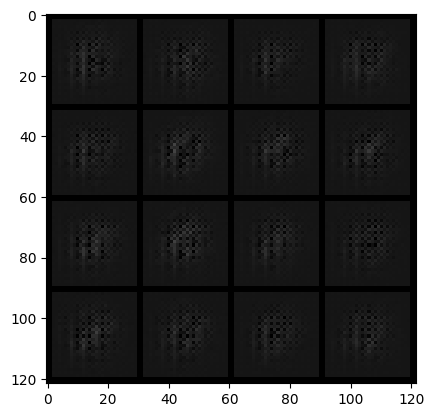

D_loss: 0.6917, G_loss: 0.6620


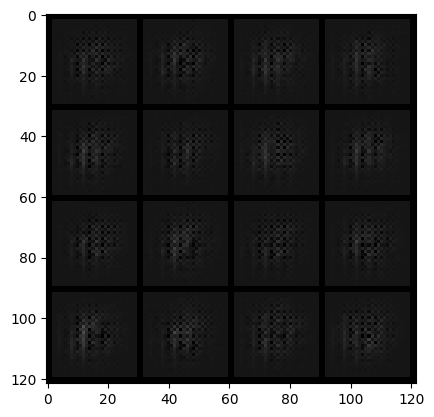

D_loss: 0.6916, G_loss: 0.6622


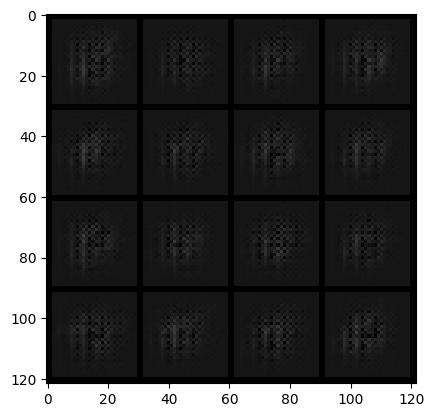

D_loss: 0.6916, G_loss: 0.6623


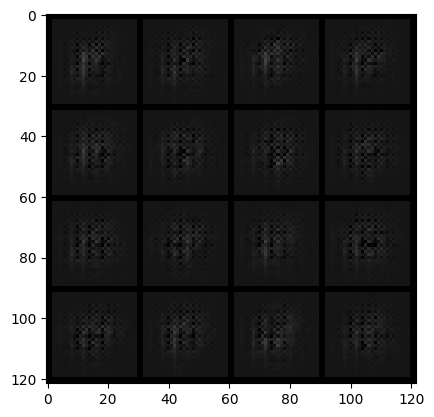

D_loss: 0.6915, G_loss: 0.6624


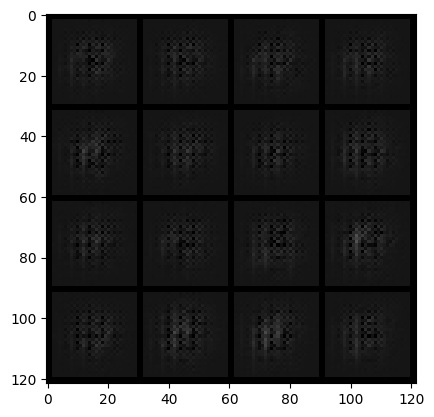

D_loss: 0.6915, G_loss: 0.6625


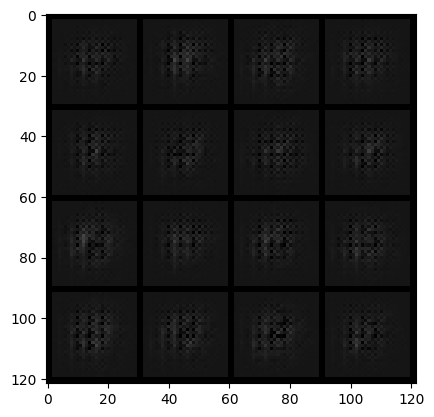

D_loss: 0.6915, G_loss: 0.6627


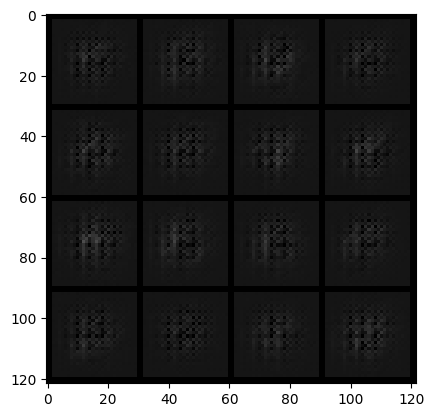

D_loss: 0.6914, G_loss: 0.6628


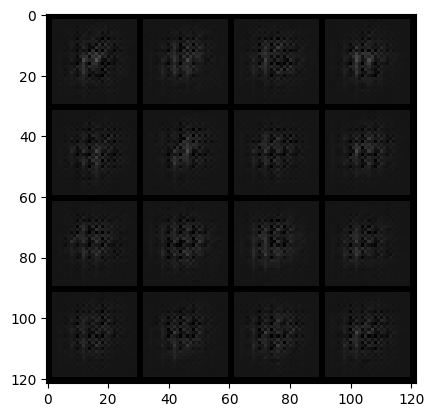

D_loss: 0.6914, G_loss: 0.6629


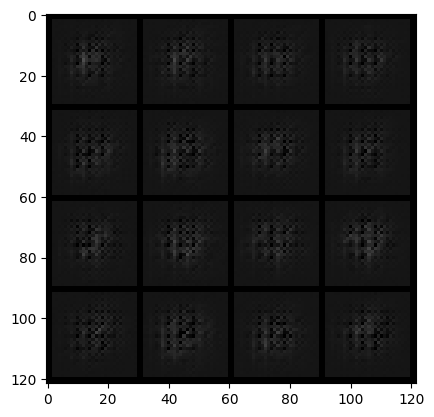

D_loss: 0.6913, G_loss: 0.6630


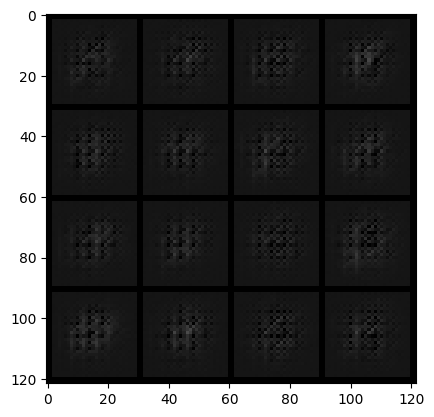

D_loss: 0.6913, G_loss: 0.6632


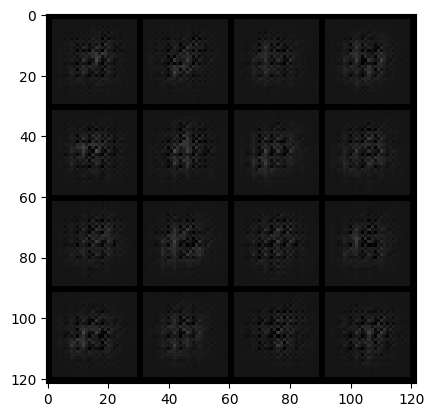

D_loss: 0.6913, G_loss: 0.6633


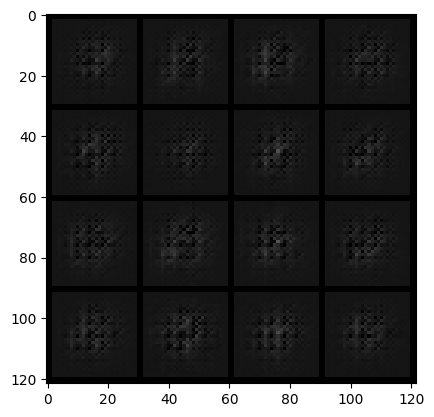

D_loss: 0.6912, G_loss: 0.6634


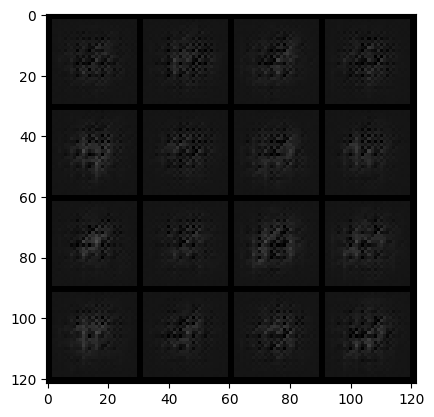

D_loss: 0.6912, G_loss: 0.6635


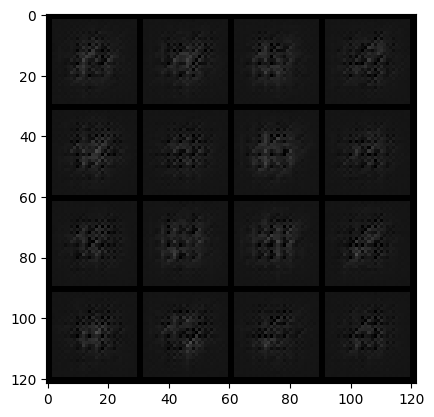

D_loss: 0.6911, G_loss: 0.6636


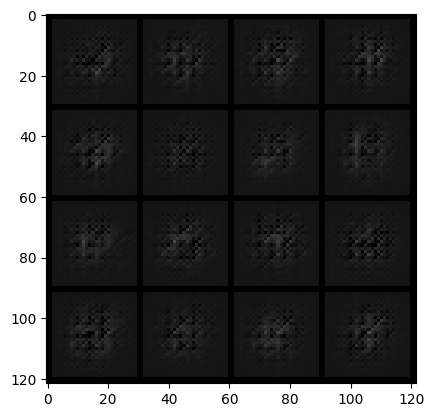

D_loss: 0.6911, G_loss: 0.6638


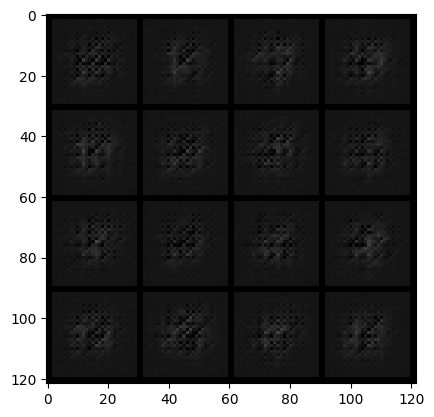

D_loss: 0.6910, G_loss: 0.6639


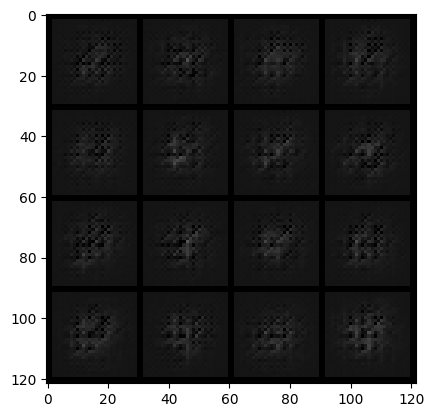

D_loss: 0.6910, G_loss: 0.6640


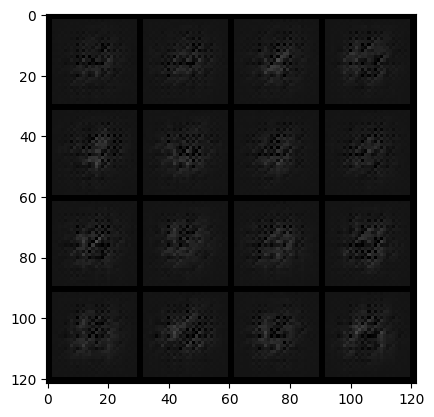

D_loss: 0.6909, G_loss: 0.6641


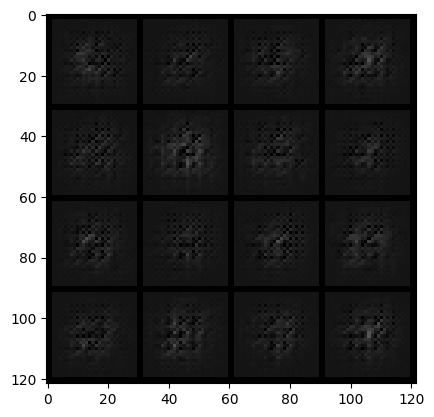

D_loss: 0.6909, G_loss: 0.6643


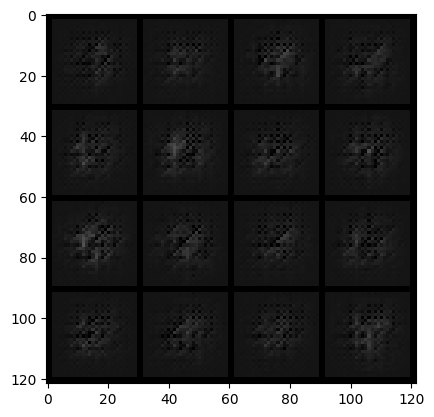

D_loss: 0.6908, G_loss: 0.6644


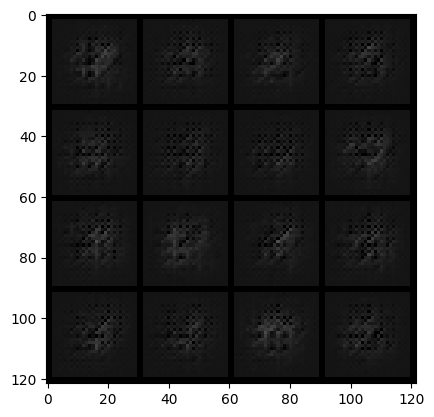

D_loss: 0.6908, G_loss: 0.6645


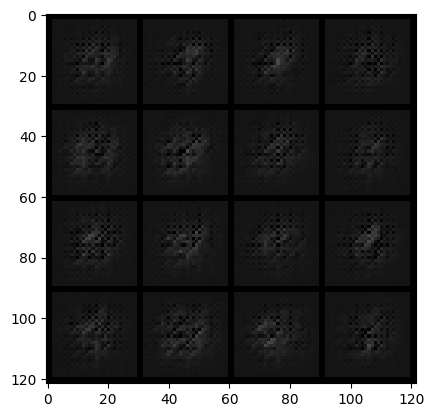

D_loss: 0.6908, G_loss: 0.6646


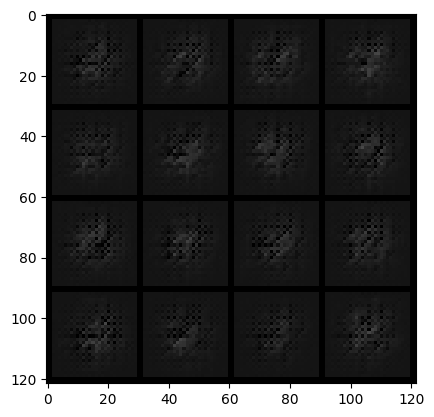

D_loss: 0.6907, G_loss: 0.6647


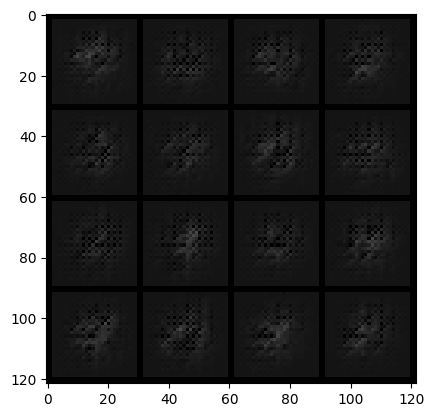

D_loss: 0.6907, G_loss: 0.6649


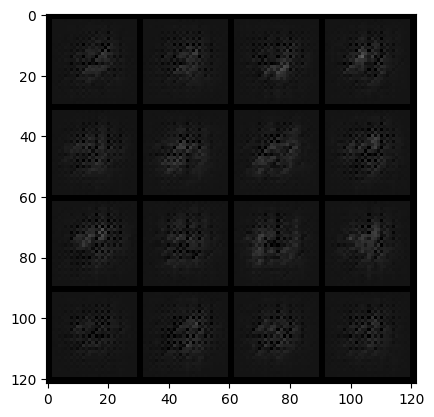

D_loss: 0.6906, G_loss: 0.6650


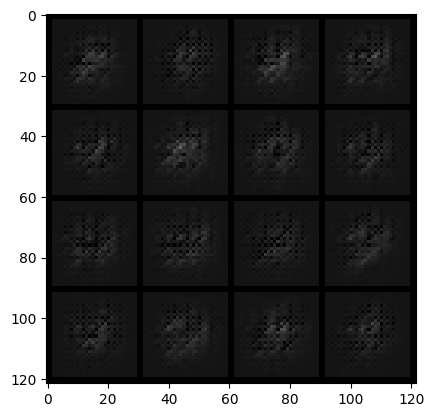

D_loss: 0.6906, G_loss: 0.6651


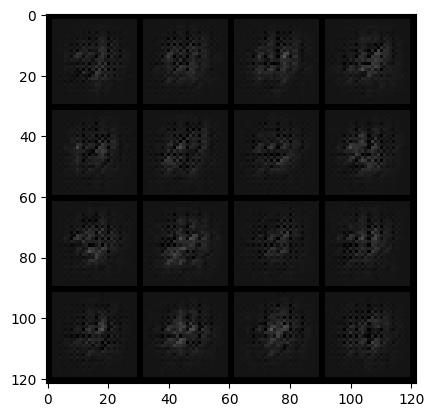

D_loss: 0.6905, G_loss: 0.6652


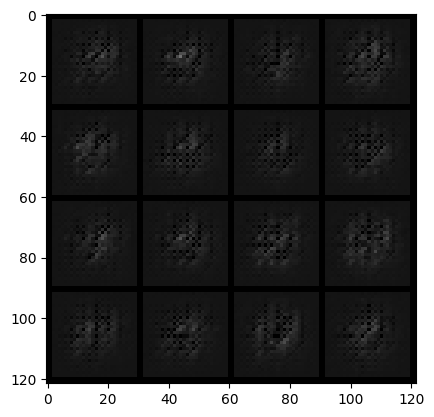

D_loss: 0.6905, G_loss: 0.6653


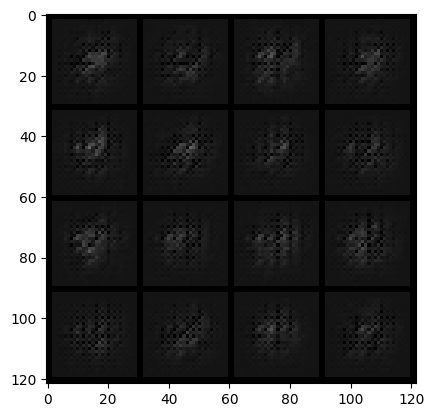

D_loss: 0.6904, G_loss: 0.6655


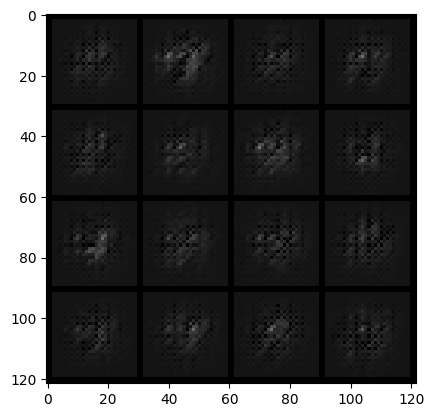

D_loss: 0.6904, G_loss: 0.6656


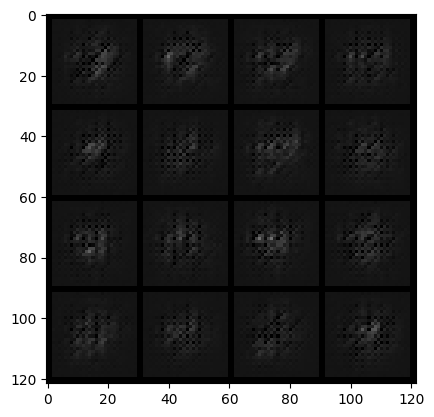

D_loss: 0.6903, G_loss: 0.6657


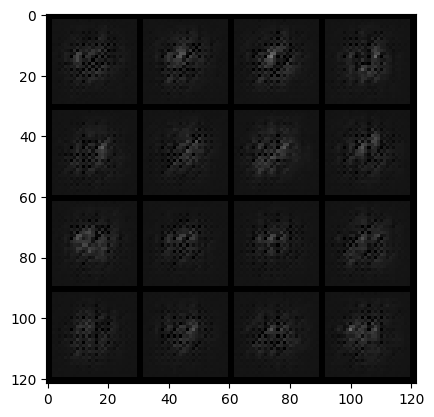

D_loss: 0.6903, G_loss: 0.6658


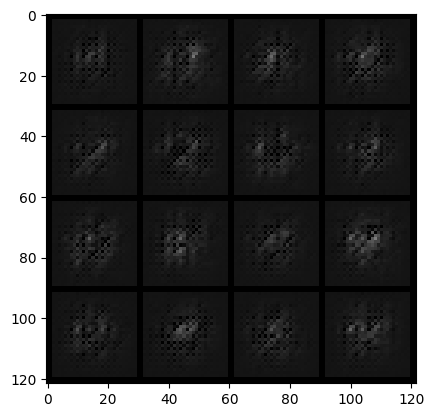

D_loss: 0.6902, G_loss: 0.6660


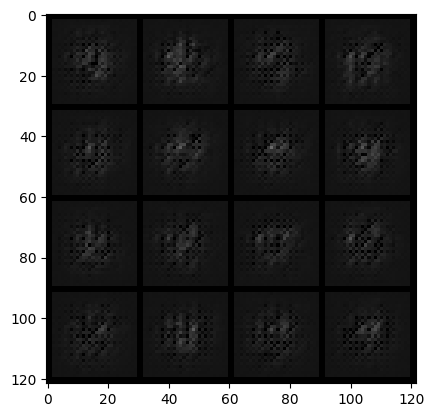

D_loss: 0.6902, G_loss: 0.6661


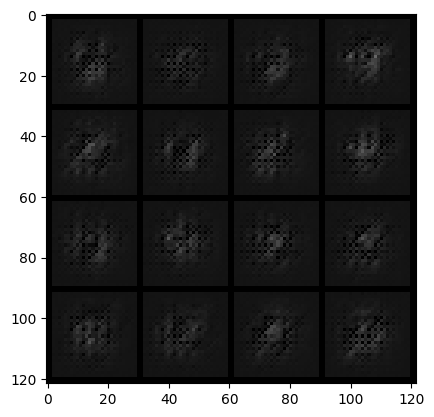

D_loss: 0.6901, G_loss: 0.6662


In [ ]:
for n in range(epochs):
  D_losses = []
  G_losses = []
  for real_images, _ in tqdm(trainloader):
    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    #Train discriminator: find loss & update weights for D nn:
    D_optimizer.zero_grad()

    fake_images = G(noise)
    D_pred_fake = D(fake_images)
    D_loss_fake = fake_loss(D_pred_fake)

    D_pred_real = D(real_images)
    D_loss_real = real_loss(D_pred_real)

    #discriminator loss is the average of real and fake losses
    D_loss = (D_loss_real + D_loss_fake)/2
    D_losses.append(D_loss.item())
    D_loss.backward()
    D_optimizer.step()

  #Train generator: find loss & update weights for G nn:
    G_optimizer.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_images = G(noise)
    D_pred_fake = D(fake_images)

    G_loss = real_loss(D_pred_fake) # since we want G to produce realistic fake images ie D_pred close to 1
    G_losses.append(G_loss.item())

    G_loss.backward()
    G_optimizer.step()

    avg_D_loss = sum(D_losses)/len(D_losses)
    avg_G_loss = sum(G_losses)/len(G_losses)

    # Print progress
    print(f"D_loss: {avg_D_loss:.4f}, G_loss: {avg_G_loss:.4f}")

    show_tensor_images(fake_images)



**Expected Behavior of the Losses:**

**D_loss**: In the early stages of training, discriminator loss will generally be low because the discriminator can easily distinguish between real and fake images because the generator produces poor-quality images.

**G_loss** In the beginning of training, generator loss is high as the generator produces poor images, so the discriminator can easily identify them as fake.

In equilibrium, both the discriminator and generator losses tend to stabilize. The discriminator will classify real and fake images with near 50% accuracy because the generator will be producing realistic images, and the discriminator won't be able to distinguish them easily.


**GAN architecture**

- We used batch normalization and advanced DCGAN (Deep Convolutional GAN). You can improve the quality of generated images by tweaking the architecture:

  **Optimization**:
- We used the Adam optimizer for both the generator and discriminator with a learning rate of `0.0002` and the recommended betas `(0.5, 0.999)` for stable training.

 **Hyperparams**:
- The model is trained for 20 epochs. You can adjust the number of epochs, batch size, or other hyperparameters as needed.


If you run this code on a GPU, it should train efficiently, but on CPU, it might take longer. Let me know if you have any questions or issues with the code!

** After training is complete**:

The model can be used to generate realistic fake handwritten images:

In [ ]:
noise = torch.randn(batch_size, noise_dim, device = device)
realistic_image = G(noise)

show_tensor_images(realistic_image)